In [42]:
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile, shutil, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, Model, Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("TF version:", tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TF version: 2.19.0


In [43]:
zip_path = "/content/drive/MyDrive/Asutosha DL 7th Sem/archive.zip"
raw_extract_dir = Path("/content/cats_and_dogs_raw")
split_base_dir = Path("/content/cats_and_dogs_split")

In [44]:
if raw_extract_dir.exists():
    shutil.rmtree(raw_extract_dir)
if split_base_dir.exists():
    shutil.rmtree(split_base_dir)

raw_extract_dir.mkdir(parents=True, exist_ok=True)
split_base_dir.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(raw_extract_dir)

print("Archive extracted to:", raw_extract_dir)

Archive extracted to: /content/cats_and_dogs_raw


In [45]:
def find_class_root(root: Path, class_names=("cats","dogs")):
    for d, dirs, files in os.walk(root):
        lower_dirs = [p.lower() for p in dirs]
        if all(cls in lower_dirs for cls in class_names):
            return Path(d)
    return None

class_root = find_class_root(raw_extract_dir, ("cats","dogs"))
if class_root is None:
    raise FileNotFoundError("Could not find 'cats' and 'dogs' directories inside the archive.")
print("Found classes at:", class_root)

Found classes at: /content/cats_and_dogs_raw/test_set/test_set


In [46]:
train_dir = split_base_dir / "train"
val_dir   = split_base_dir / "validation"

for cls in ["cats", "dogs"]:
    (train_dir / cls).mkdir(parents=True, exist_ok=True)
    (val_dir / cls).mkdir(parents=True, exist_ok=True)

In [47]:
def stratified_copy(src_class_dir: Path, dst_train: Path, dst_val: Path, train_ratio=0.8):
    files = [f for f in src_class_dir.iterdir() if f.is_file()]
    files = sorted(files)
    random.Random(SEED).shuffle(files)   # deterministic shuffle with seed
    split_idx = int(len(files) * train_ratio)
    for f in files[:split_idx]:
        shutil.copy(f, dst_train / f.name)
    for f in files[split_idx:]:
        shutil.copy(f, dst_val / f.name)
    return split_idx, len(files) - split_idx

cat_src = class_root / "cats"
dog_src = class_root / "dogs"

cat_train_n, cat_val_n = stratified_copy(cat_src, train_dir/"cats", val_dir/"cats")
dog_train_n, dog_val_n = stratified_copy(dog_src, train_dir/"dogs", val_dir/"dogs")

print(f"Copied files — cats: train {cat_train_n}, val {cat_val_n} | dogs: train {dog_train_n}, val {dog_val_n}")

Copied files — cats: train 809, val 203 | dogs: train 810, val 203


In [48]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [49]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Classes (train_ds.class_names):", train_ds.class_names)

Found 1617 files belonging to 2 classes.
Found 406 files belonging to 2 classes.
Classes (train_ds.class_names): ['cats', 'dogs']


In [50]:
train_augment = tf.keras.Sequential([
    Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.08)
], name="train_augment")

val_preprocess = tf.keras.Sequential([
    Rescaling(1./255)
], name="val_preprocess")


In [51]:
tl_train_preprocess = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1)
], name="tl_train_preprocess")
tl_val_preprocess = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1)
], name="tl_val_preprocess")


ds_scratch_train = train_ds.map(lambda x, y: (train_augment(x), y), num_parallel_calls=AUTOTUNE)
ds_scratch_val   = val_ds.map(lambda x, y: (val_preprocess(x), y), num_parallel_calls=AUTOTUNE)

ds_scratch_train = ds_scratch_train.cache().prefetch(AUTOTUNE)
ds_scratch_val   = ds_scratch_val.cache().prefetch(AUTOTUNE)


ds_tl_train = train_ds.map(lambda x, y: (tl_train_preprocess(x), y), num_parallel_calls=AUTOTUNE)
ds_tl_val   = val_ds.map(lambda x, y: (tl_val_preprocess(x), y), num_parallel_calls=AUTOTUNE)

ds_tl_train = ds_tl_train.cache().prefetch(AUTOTUNE)
ds_tl_val   = ds_tl_val.cache().prefetch(AUTOTUNE)

In [52]:
from tensorflow.keras.layers import Input

scratch_model = Sequential([
    Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

scratch_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
scratch_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),   # smaller LR
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

EPOCHS = 12
history_scratch = scratch_model.fit(
    ds_scratch_train,
    epochs=EPOCHS,
    validation_data=ds_scratch_val,
    callbacks=callbacks
)


Epoch 1/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5012 - loss: 0.7022 - val_accuracy: 0.5296 - val_loss: 0.6834
Epoch 2/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5533 - loss: 0.6849 - val_accuracy: 0.5468 - val_loss: 0.6765
Epoch 3/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5939 - loss: 0.6772 - val_accuracy: 0.6305 - val_loss: 0.6597
Epoch 4/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6073 - loss: 0.6621 - val_accuracy: 0.6527 - val_loss: 0.6373
Epoch 5/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6453 - loss: 0.6447 - val_accuracy: 0.6576 - val_loss: 0.6158
Epoch 6/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6699 - loss: 0.6208 - val_accuracy: 0.6650 - val_loss: 0.6105
Epoch 7/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6975 - loss: 0.6043 - val_accuracy: 0.6921 - val_loss: 0.5933
Epoch 8/12
51/51 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6983 - loss: 0.6042 - val_accuracy: 0.6601 - val_loss:

# Quick MobileNetV2 transfer-learning (Accuracy was really coming low so tried it to improve)

In [54]:
from tensorflow.keras import Model
base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet',
    pooling=None
)
base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [55]:
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
tl_model = Model(inputs, outputs)

tl_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history_tl = tl_model.fit(
    ds_tl_train,
    epochs=8,
    validation_data=ds_tl_val,
    callbacks=callbacks
)


base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

tl_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

history_tl_fine = tl_model.fit(
    ds_tl_train,
    epochs=6,
    validation_data=ds_tl_val,
    callbacks=callbacks
)


Epoch 1/8
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 565ms/step - accuracy: 0.5446 - loss: 0.7836 - val_accuracy: 0.6823 - val_loss: 0.5942
Epoch 2/8
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 502ms/step - accuracy: 0.7053 - loss: 0.5868 - val_accuracy: 0.8276 - val_loss: 0.4346
Epoch 3/8
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 489ms/step - accuracy: 0.8164 - loss: 0.4302 - val_accuracy: 0.8867 - val_loss: 0.3347
Epoch 4/8
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 471ms/step - accuracy: 0.8581 - loss: 0.3602 - val_accuracy: 0.9261 - val_loss: 0.2707
Epoch 5/8
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 579ms/step - accuracy: 0.9038 - loss: 0.2916 - val_accuracy: 0.9458 - val_loss: 0.2273
Epoch 6/8
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 495ms/step - accuracy: 0.9207 - loss: 0.2521 - val_accuracy: 0.9557 - val_loss: 0.1972
Epoch 7/8
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 576ms/step - accuracy: 0.9349 - loss: 0.2188 - val_accuracy: 0.9606 - val_loss: 0.1751
Epoch 8/8
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 492ms/step - accuracy: 0.9315 - loss: 0.2066 - val_accuracy: 0.

In [61]:
hist = history_tl

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

final_train_acc  = acc[-1]
final_val_acc    = val_acc[-1]
final_train_loss = loss[-1]
final_val_loss   = val_loss[-1]

best_val_acc  = max(val_acc)
best_epoch    = val_acc.index(best_val_acc) + 1

print("====== Training Summary ======")
print(f"Final Training Accuracy   : {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy : {final_val_acc*100:.2f}%")
print(f"Final Training Loss       : {final_train_loss:.4f}")
print(f"Final Validation Loss     : {final_val_loss:.4f}")
print(f"Best Validation Accuracy  : {best_val_acc*100:.2f}% at epoch {best_epoch}")


====== Training Summary ======
Final Training Accuracy   : 94.25%
Final Validation Accuracy : 96.31%
Final Training Loss       : 0.1968
Final Validation Loss     : 0.1582
Best Validation Accuracy  : 96.31% at epoch 8


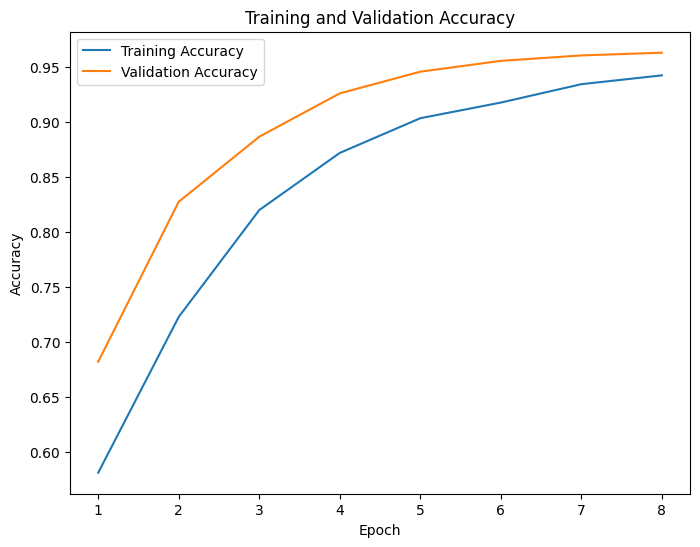

In [63]:
epochs_range = range(1, len(acc)+1)
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(epochs_range, acc, label='Training Accuracy')
ax.plot(epochs_range, val_acc, label='Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy')
ax.legend()
plt.show()

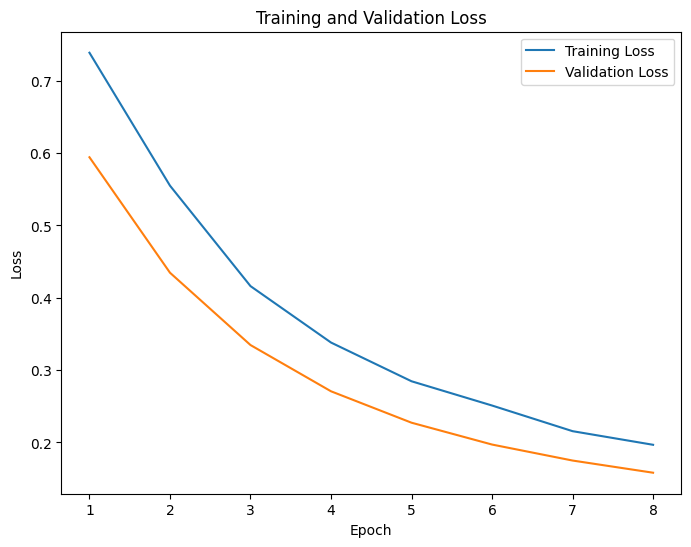

In [64]:
fig ,ax = plt.subplots(figsize=(8,6))
ax.plot(epochs_range, loss, label='Training Loss')
ax.plot(epochs_range, val_loss, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()

plt.show()

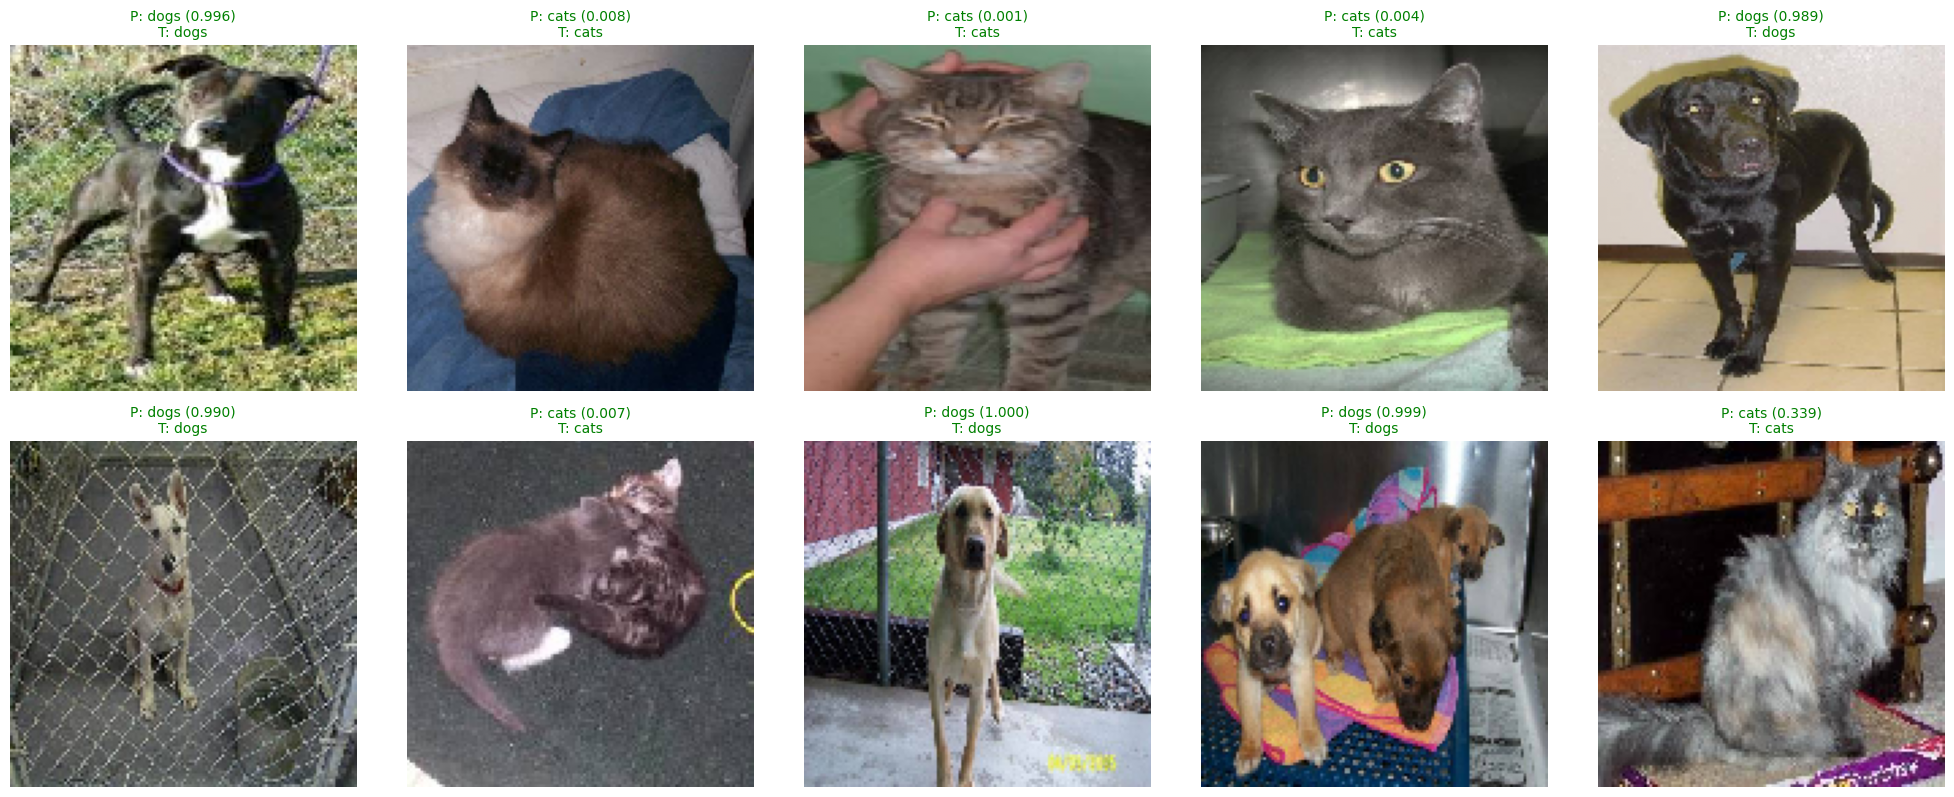

In [69]:
from pathlib import Path

def predict_and_show(img_path, model=model_to_use, size=IMG_SIZE):

    pil_img = image.load_img(img_path, target_size=size)
    display_arr = image.img_to_array(pil_img).astype(np.uint8)


    proc = image.img_to_array(pil_img)
    if model is scratch_model:
        proc = proc / 255.0
    else:
        proc = (proc / 127.5) - 1.0
    proc = np.expand_dims(proc, axis=0)

    prob = float(model.predict(proc, verbose=0)[0][0])
    pred_label = class_names[int(prob > 0.5)]

    true_label = Path(img_path).parent.name

    correct = (pred_label == true_label)
    title_color = "green" if correct else "red"
    title_text = f"P: {pred_label} ({prob:.3f})\nT: {true_label}"

    plt.imshow(display_arr.astype(np.uint8).astype(float)/255.0)
    plt.title(title_text, color=title_color, fontsize=10)
    plt.axis('off')

n_examples = min(10, len(all_val_paths))
sample_paths = random.sample(all_val_paths, n_examples)

rows, cols = 4, 5
plt.figure(figsize=(20, 16))
for i, p in enumerate(sample_paths, 1):
    plt.subplot(rows, cols, i)
    predict_and_show(p)
plt.tight_layout()
plt.show()
